#TODO: figure out how I can integrate the knowledge of last sleep stage into my research

# Utilities

In [1]:
import numpy as np
import scipy as spy
import pandas as pd
from pathlib import Path
import mne
import matplotlib.pyplot as plt
import seaborn as sns
import mne

In [2]:
def read_dream_interpretation(path: Path):
    interpretation = pd.read_csv(path, sep=',')
    return interpretation

In [3]:
def read_eeg(path:Path):
    raw = mne.io.read_raw_edf("./data/PSG/"+path, preload=True)

    data, times = raw.get_data(return_times=True)
    ch_names = raw.ch_names
    
    df = pd.DataFrame(data.T, columns=ch_names)
    df["time_s"] = times
    return df


In [4]:
def plot_dataframe_signals(df: pd.DataFrame, title: str, max_samples = None, time_col: str = None):
    sns.set_style("whitegrid")

    df_plot = df.copy()
    
    if max_samples != None and max_samples < len(df_plot):
        new_indices = np.linspace(0, len(df_plot), max_samples, endpoint=False, dtype=np.int32)
        df_plot = df_plot.iloc[new_indices]

    if time_col and time_col in df_plot.columns:
        x = df_plot[time_col].values
        xlabel = "Time [s]"
        df_plot = df_plot.drop(columns=[time_col])
    else:
        x = np.arange(len(df_plot))
        xlabel = "Samples"
    

    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns

    plt.figure(figsize=(15, 6))
    for col in numeric_cols:
        sns.lineplot(x=x, y=df_plot[col], label=col)

    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel(xlabel)
    plt.ylabel("Amplitude")
    plt.legend(title="Channels", loc="best")
    plt.grid(True, which="major", linestyle="--", alpha=0.6)
    plt.grid(True, which="minor", linestyle=":", alpha=0.3)
    plt.gca().set_facecolor("lightblue")

    plt.tight_layout()
    plt.show()


In [5]:
def plot_dataframe_fft(df: pd.DataFrame, title: str, fs: float = None, time_col: str = None):
    sns.set_style("whitegrid")
    df_plot = df.copy()

    if time_col and time_col in df_plot.columns:
        time = df_plot[time_col].values
        df_plot = df_plot.drop(columns=[time_col])
        if fs is None:
            if len(time) > 1:
                fs = 1.0 / np.mean(np.diff(time))
                print(f"Inferred sampling frequecny: {fs}")
            else:
                raise ValueError("Not enough time samples to infer sampling frequency.")
    elif fs is None:
        raise ValueError("Sampling frequency 'fs' must be provided if no time column is given.")

    numeric_cols = df_plot.select_dtypes(include=[np.number]).columns
    n = len(df_plot)

    freqs = spy.fft.rfftfreq(n, d=1/fs)

    plt.figure(figsize=(15, 6))
    for col in numeric_cols:
        sig = df_plot[col].values
        fft_vals = spy.fft.rfft(sig)
        amplitude = np.abs(fft_vals) / (n / 2)
        amplitude = 10 * np.log10(amplitude + 1e-20)
        sns.lineplot(x=freqs, y=amplitude, label=col)

    plt.title(title + " — Amplitude Spectrum", fontsize=14, weight="bold")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [dB]")
    plt.legend(title="Channels", loc="best")
    plt.grid(True, which="major", linestyle="--", alpha=0.6)
    plt.grid(True, which="minor", linestyle=":", alpha=0.3)
    plt.gca().set_facecolor("lightblue")
    plt.tight_layout()
    plt.show()


In [6]:
def extract_brain_frequency(df : pd.DataFrame, fs, bPass, bStop, maxLoss, minAttenuation):
    ord, w = spy.signal.cheb1ord(bPass, bStop, maxLoss, minAttenuation, analog=False, fs=fs)
    
    ripple = 3
    b, a = spy.signal.cheby1(ord, ripple, w, analog=False, fs=fs, btype="bandpass")
    
    print(f"Filter order: {ord}")
    
    for column in df.columns:
        df.assign(column = spy.signal.lfilter(b, a, df[column]))
    
    return df
    

In [7]:
def extract_region_of_interest(df : pd.DataFrame, fs, maxLoss, minAttenuation):
    w, ord = spy.signal.buttord([0.5, 35], [0, 35.5], maxLoss, minAttenuation, analog=False, fs=fs)
    print(f"Filter order: {ord}")
    b, a = spy.signal.butter(ord, w, analog=False, fs=fs, type="bandpass")

    for column in df.columns:
        df.assign(column = spy.signal.lfilter(b, a, df[column]))
    
    return df

In [8]:
def apply_window(df : pd.DataFrame):
    kaiser_window = spy.signal.windows.get_window(("kaiser", 2), len(df))
    for column in df.columns:
        df.assign(column = kaiser_window * df[column])
        
    return df

In [9]:
def get_rid_of_bad_channels(patient_recording_id : str, patient_recording : pd.DataFrame, recordings_meta : pd.DataFrame):
    bad_channels_str = recordings_meta[recordings_meta["Filename"] == f"{patient_recording_id}.edf"]["Bad channels"].to_string().strip()

    try:
        bad_channels = [int(k)-1 for k in bad_channels_str.split()[1:]] #channels are indexed from 1 + index must be removed
    except:
        return patient_recording.columns[:7]
    
    print(f"Bad eeg channels: {patient_recording.columns[bad_channels]}")
    
    good_channels = []
    for i in range(7):
        if i not in bad_channels:
            good_channels.append(patient_recording.columns[i])
            
    print(f"Good eeg channels: {good_channels}")
            
    patient_recording.drop(columns=patient_recording.columns[bad_channels], inplace=True)
    return good_channels

In [10]:
def plot_dreem_topomap(metrics, channel_names, fs=128, title="Topomap", value_label="Some stupid value"):
    """
    Plot a topomap for DREEM bipolar signals using midpoint-based electrode positions.
    """

    montage_1020 = mne.channels.make_standard_montage("standard_1020")
    pos_std = montage_1020.get_positions()["ch_pos"]

    # Compute midpoint
    def midpoint(a, b):
        return (pos_std[a] + pos_std[b]) / 2

    dreem_positions = {
        "EEG Fp1-O1": midpoint("Fp1", "O1"),
        "EEG Fp1-O2": midpoint("Fp1", "O2"),
        "EEG Fp1-F7": midpoint("Fp1", "F7"),
        "EEG F8-F7":  midpoint("F8", "F7"),
        "EEG F7-O1": midpoint("F7", "O1"),
        "EEG F8-O2": midpoint("F8", "O2"),
        "EEG Fp1-F8": midpoint("Fp1", "F8")
    }

    used_positions = {ch: dreem_positions[ch] for ch in channel_names}

    dig_montage = mne.channels.make_dig_montage(
        ch_pos=used_positions,
        coord_frame="head"
    )

    info = mne.create_info(
        ch_names=list(used_positions.keys()),
        sfreq=fs,
        ch_types="eeg"
    )
    info.set_montage(dig_montage)

    fig, ax = plt.subplots(figsize=(6, 5))
    im, _ = mne.viz.plot_topomap(
        np.asarray(metrics),
        pos=info,             
        axes=ax,
        cmap="viridis",
        show=False
    )

    ax.set_title(title)
    plt.colorbar(im, ax=ax, label=value_label)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mne
import re

%matplotlib widget

def animate_dreem_topomap(metrics_time,
                          channel_names,
                          fs=128,
                          title="Animated Topomap",
                          value_label="Some stupid value",
                          interval=100,
                          save=False,
                          fps=15,
                          format="gif"):
    """
    Animate topomap for DREEM bipolar EEG signals.

    Parameters
    ----------
    metrics_time : np.ndarray
        (time, n_channels)
    channel_names : list
        Channel labels
    save : bool
        Save to file if True
    format : str
        'gif' or 'mp4'
    """

    metrics_time = np.asarray(metrics_time)
    n_time, n_ch = metrics_time.shape

    if len(channel_names) != n_ch:
        raise ValueError("Number of channel names must match metrics_time.shape[1]")

    safe_title = re.sub(r'[^a-zA-Z0-9_\- ]', '', title).replace(" ", "_")

    # --------- Standard 10–20 positions ---------
    montage_1020 = mne.channels.make_standard_montage("standard_1020")
    pos_std = montage_1020.get_positions()["ch_pos"]

    def midpoint(a, b):
        return (pos_std[a] + pos_std[b]) / 2

    dreem_positions = {
        "EEG Fp1-O1": midpoint("Fp1", "O1"),
        "EEG Fp1-O2": midpoint("Fp1", "O2"),
        "EEG Fp1-F8": midpoint("Fp1", "F8"), #frontal right
        "EEG Fp1-F7": midpoint("Fp1", "F7"), #frontal left
        
        "EEG F8-F7":  midpoint("F8", "F7"),
        "EEG F8-O2":  midpoint("F8", "O2"),
        
        "EEG F7-O1":  midpoint("F7", "O1"),
    }

    used_positions = {ch: dreem_positions[ch] for ch in channel_names}

    dig_montage = mne.channels.make_dig_montage(
        ch_pos=used_positions,
        coord_frame="head"
    )

    info = mne.create_info(
        ch_names=list(used_positions.keys()),
        sfreq=fs,
        ch_types="eeg"
    )
    info.set_montage(dig_montage)

    vmin = np.min(metrics_time)
    vmax = np.max(metrics_time)

    fig, ax = plt.subplots(figsize=(6, 5))

    im, _ = mne.viz.plot_topomap(
        metrics_time[0],
        pos=info,
        axes=ax,
        show=False,
        cmap="viridis",
        vlim=(vmin, vmax)
    )

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_label)

    ax.set_title(f"{title}\nFrame: 0")

    def update(frame):
        ax.clear()

        im, _ = mne.viz.plot_topomap(
            metrics_time[frame],
            pos=info,
            axes=ax,
            show=False,
            cmap="viridis",
            vlim=(vmin, vmax)
        )

        ax.set_title(f"{title}\nFrame: {frame}")
        return [im]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=n_time,
        interval=interval,
        blit=False,
        repeat=False
    )

    if save:
        if format.lower() == "gif":
            from matplotlib.animation import PillowWriter
            writer = PillowWriter(fps=fps)
            filename = f"{safe_title}.gif"
            ani.save(filename, writer=writer)

        elif format.lower() == "mp4":
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, bitrate=1800)
            filename = f"{safe_title}.mp4"
            ani.save(filename, writer=writer)

        else:
            raise ValueError("format must be 'gif' or 'mp4'")

    plt.show()
    return ani


In [12]:
def compute_psd(df : pd.DataFrame, fs, window, window_duration, overlap_ratio, freq_band, use_db = True, normalize_power = False) -> pd.DataFrame :    
    win_point_length = int(fs 
                           * window_duration)
    win_point_overlap = int(win_point_length * overlap_ratio)

    mean_psds = {} 

    for signal in df.columns:
        f, t, Sxx = spy.signal.spectrogram(
            df[signal],
            fs=fs,
            window=window,
            nperseg=win_point_length,
            noverlap=win_point_overlap,
            scaling='density',
            mode='psd',
            return_onesided=True
        )
        
        f_low, f_high = freq_band
        band_mask = (f >= f_low) & (f <= f_high)
        band_avg_psd = np.mean(Sxx[band_mask, :], axis=0)
                
        if use_db:
            band_avg_psd = 10 * np.log10(band_avg_psd + 1e-20)
        mean_psds[signal] = band_avg_psd
        
    mean_as_dict = pd.DataFrame.from_dict(mean_psds)
    
    if normalize_power:
        mean_psd_np = mean_as_dict.to_numpy() #this sucks but we are doing python after all
        norms = np.linalg.norm(mean_psd_np, axis=1)
        mean_psd_np = mean_psd_np / norms[:, None]
        mean_as_dict = pd.DataFrame(mean_psd_np)
        mean_as_dict.columns = df.columns
            
    mean_as_dict.set_index(t, inplace=True) 

    return mean_as_dict

In [13]:
def plot_mean_spectral_density(
    signals_df: pd.DataFrame, 
    fs: float, 
    window: str, 
    window_duration: float, 
    overlap_ratio: float, 
    freq_band: tuple, 
    use_db: bool = True
):  
    win_point_length = int(fs * window_duration)
    win_point_overlap = int(win_point_length * overlap_ratio)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))

    f_low, f_high = freq_band
    
    ylabel = "Average PSD [dB/Hz]" if use_db else "Average PSD [V²/Hz]"
    title = f"Average PSD in {f_low:.1f}-{f_high:.1f} Hz Band"

    for signal_name in signals_df.columns:
        signal = signals_df[signal_name].values
        
        f, t, Sxx = spy.signal.spectrogram(
            signal,
            fs=fs,
            window=window,
            nperseg=win_point_length,
            noverlap=win_point_overlap,
            scaling='density',
            mode='psd',
            return_onesided=True
        )

        band_mask = (f >= f_low) & (f <= f_high)
        band_avg_psd = np.mean(Sxx[band_mask, :], axis=0)
        
        if use_db:
            band_avg_psd_to_plot = 10 * np.log10(band_avg_psd + 1e-20)
        else:
            band_avg_psd_to_plot = band_avg_psd
            
        ax.plot(
            t, 
            band_avg_psd_to_plot, 
            linewidth=1.8, 
            label=signal_name
        )
        
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time [s]", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor("whitesmoke")
    ax.legend(title="Signals", loc="best") 

    plt.tight_layout()
    plt.show()

# Common

In [14]:
interpretation = read_dream_interpretation("./data/reports_interpreted.csv")
meta = pd.read_csv("./data/Records.csv") 

In [15]:
nightmare_subjects = interpretation[interpretation["Classification"] == "Nightmare"]
num_nightmare_subjects = len(nightmare_subjects)
print(f"Num nightmare entries: {num_nightmare_subjects}")

neutral_subjects = interpretation[interpretation["Classification"] == "Neutral"]
num_neutral_subjects = len(neutral_subjects)
print(f"Num neutral entries: {num_neutral_subjects}")

unpleasant_subjects = interpretation[interpretation["Classification"] == "Unpleasant/Anxious"]
num_unpleasant_subjects = len(unpleasant_subjects)
print(f"Num unpleasant entries: {num_unpleasant_subjects}")

Num nightmare entries: 10
Num neutral entries: 38
Num unpleasant entries: 59


# Start

In [16]:
subject_name = "DL014/DL014_night03"
subject = read_eeg(f"/{subject_name}.edf")

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...


In [17]:
available_eeg_channels = get_rid_of_bad_channels(subject_name, subject, meta)

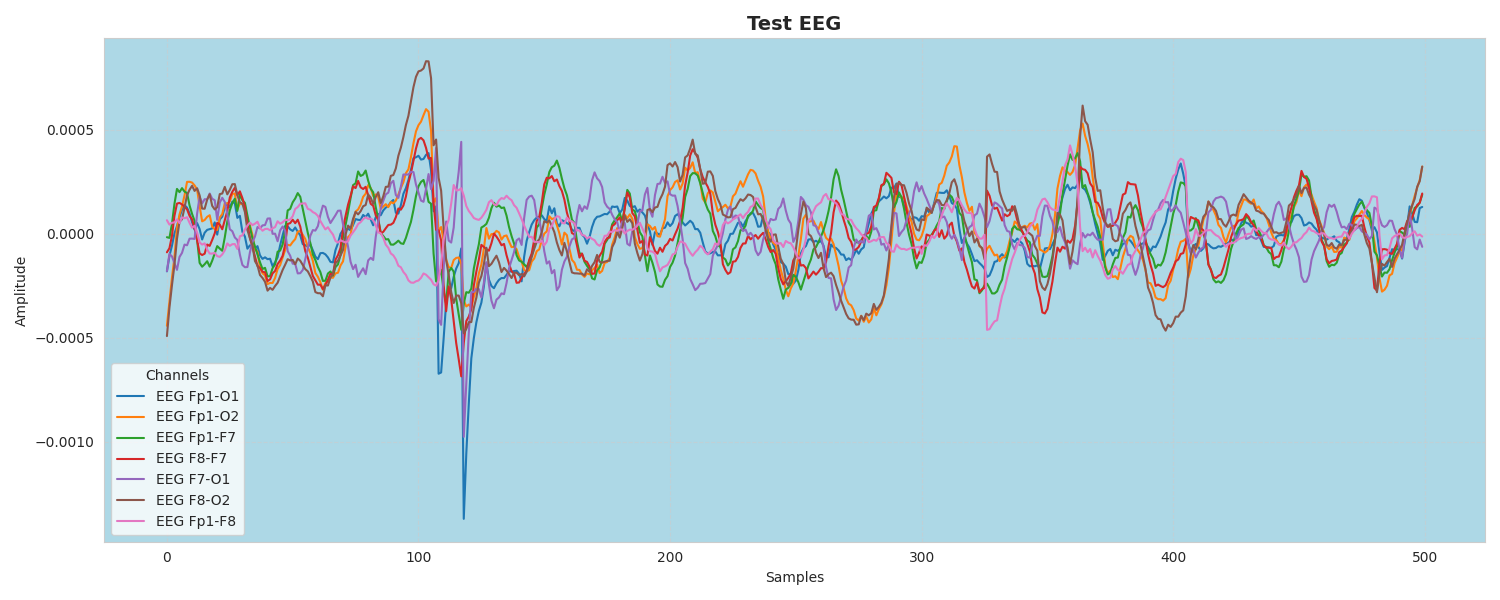

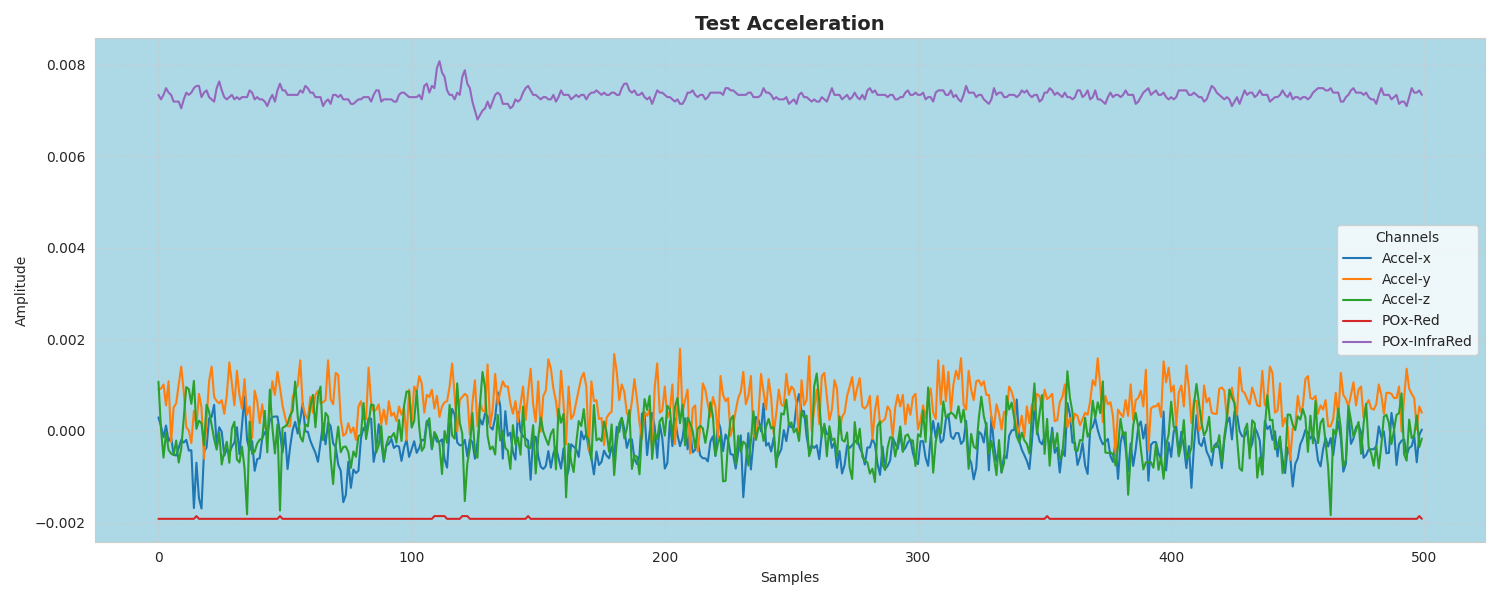

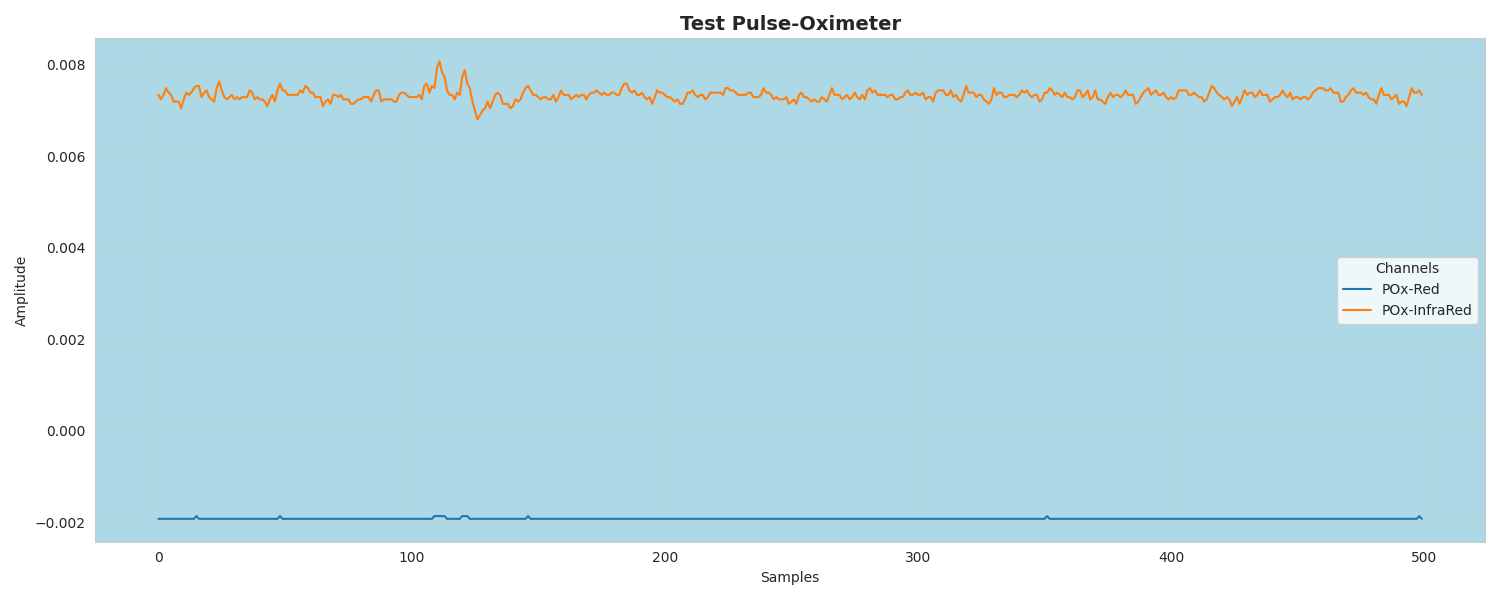

In [18]:
plot_dataframe_signals(
    subject[
        available_eeg_channels
    ],
    "Test EEG",
    500,
    None,
)
plot_dataframe_signals(
    subject[["Accel-x", "Accel-y", "Accel-z", "POx-Red", "POx-InfraRed"]],
    "Test Acceleration",
    500,
    None,
)

plot_dataframe_signals(
    subject[["POx-Red", "POx-InfraRed"]],
    "Test Pulse-Oximeter",
    500,
    None,
)

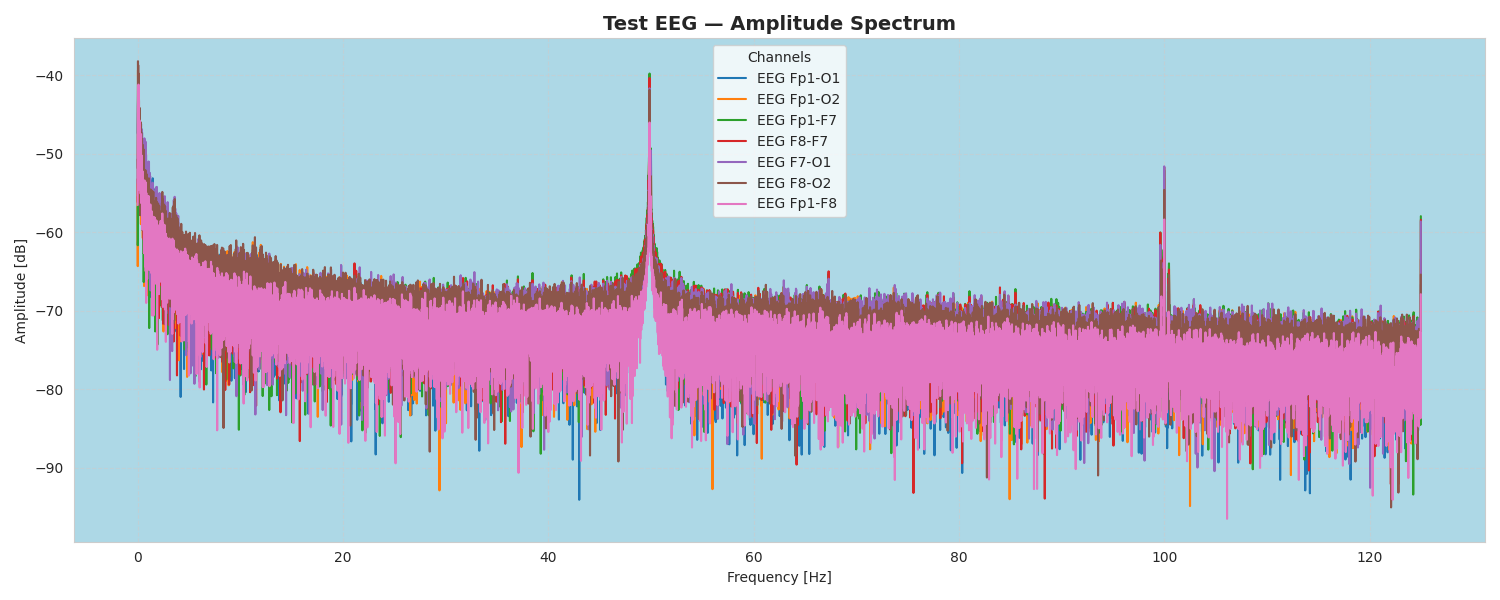

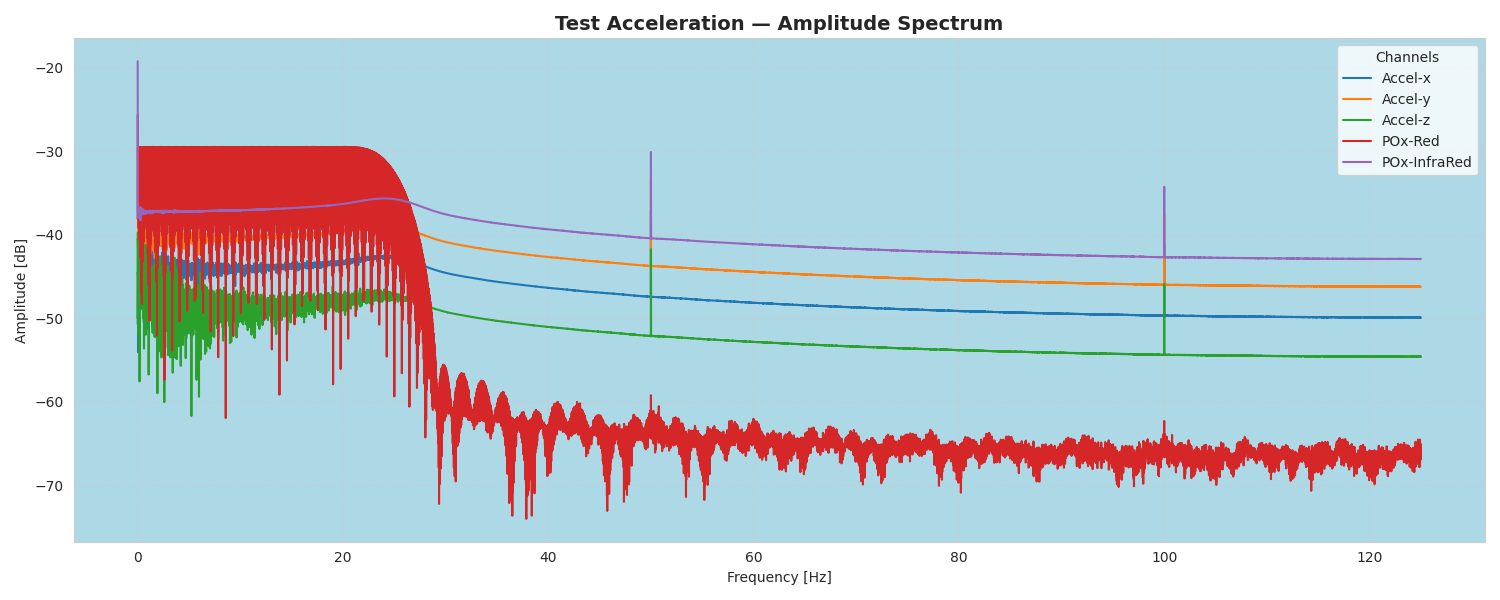

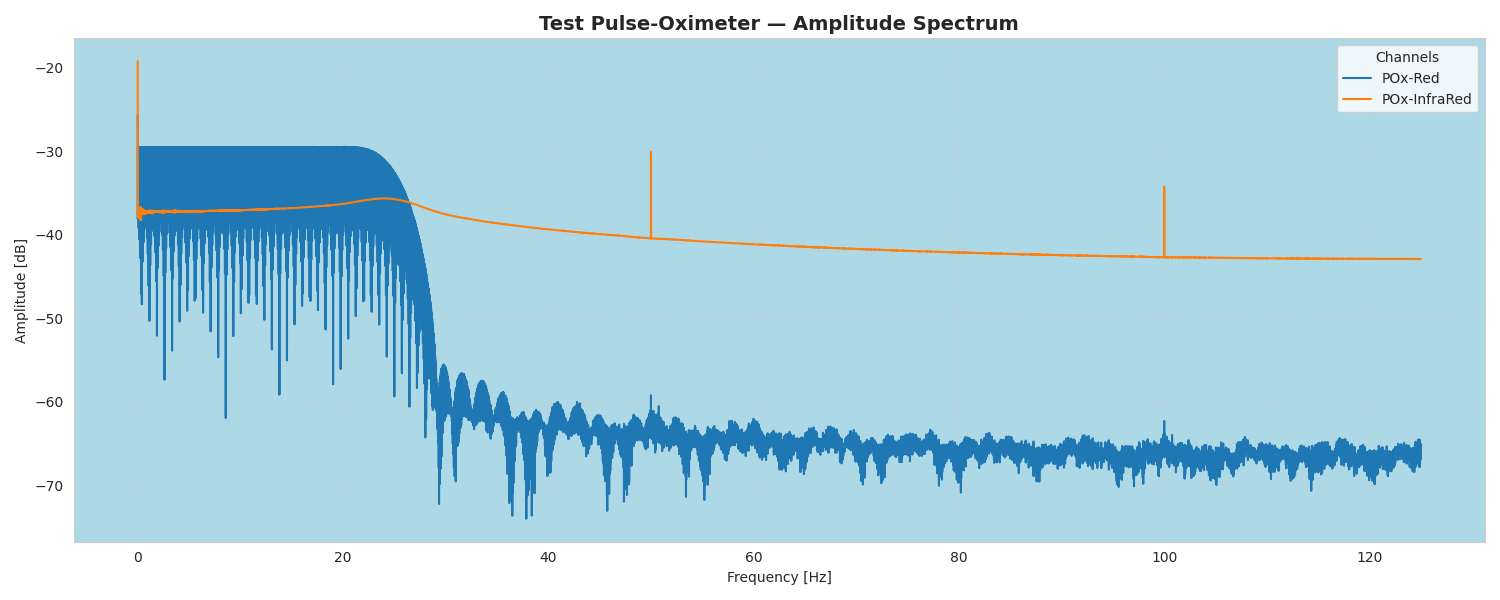

In [19]:
plot_dataframe_fft(
    subject[
        available_eeg_channels
    ],
    "Test EEG",
    250,
    None,
)
plot_dataframe_fft(
    subject[["Accel-x", "Accel-y", "Accel-z", "POx-Red", "POx-InfraRed"]],
    "Test Acceleration",
    250,
    None,
)

plot_dataframe_fft(
    subject[["POx-Red", "POx-InfraRed"]],
    "Test Pulse-Oximeter",
    250,
    None,
)

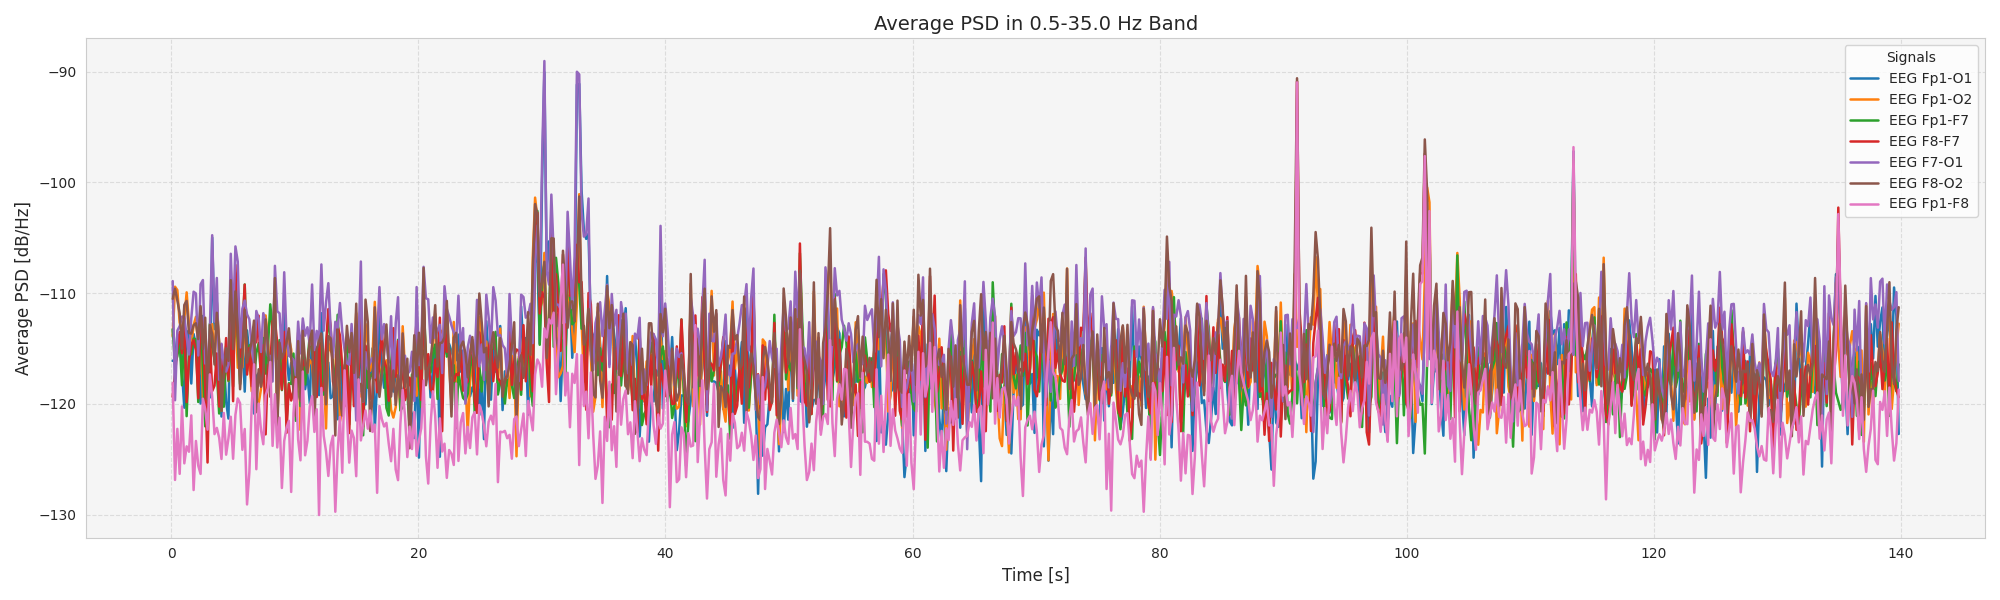

In [20]:
plot_mean_spectral_density(subject[available_eeg_channels], 250, "hamming", 0.25, 0.25, (0.5, 35))

Filter order: 4
(744, 7)
Index(['EEG Fp1-O1', 'EEG Fp1-O2', 'EEG Fp1-F7', 'EEG F8-F7', 'EEG F7-O1',
       'EEG F8-O2', 'EEG Fp1-F8'],
      dtype='object')
(7,)


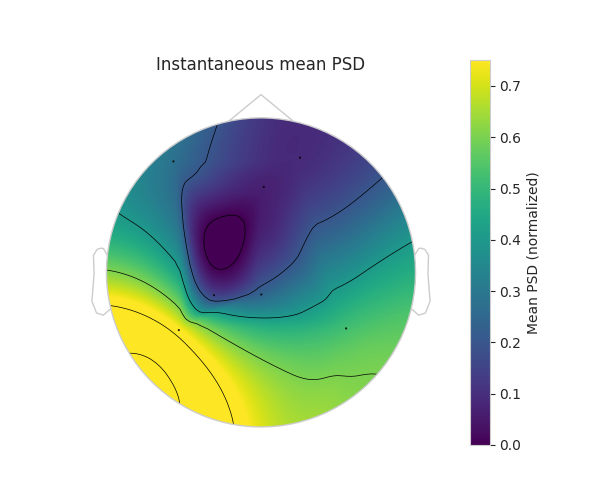

In [21]:
frequency_of_interest = extract_brain_frequency(subject[available_eeg_channels], 250, [8, 12], [7,13], 2, 15)
windowed_frequency = apply_window(frequency_of_interest)

mean_psd = compute_psd(windowed_frequency, 250, "hamming", 0.25, 0.25, (0.5, 35), False)

print(mean_psd.to_numpy().shape)

time_slice = mean_psd.to_numpy()[0,:]  #rows - time, cols - channels
time_slice = time_slice / np.linalg.norm(time_slice)

print(available_eeg_channels)
print(time_slice.shape)

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (normalized)")


(744,)
(744, 7)


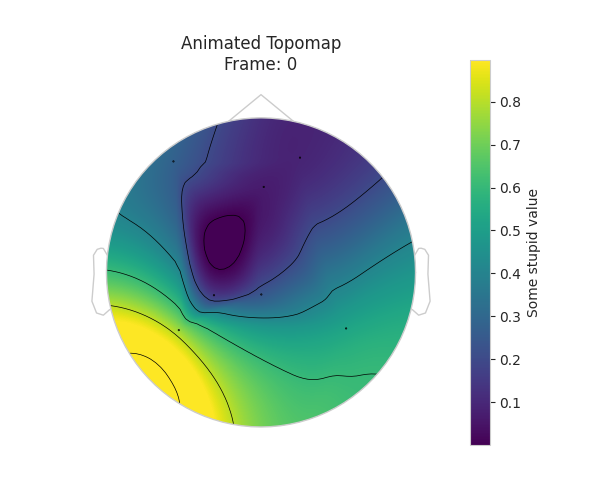

In [22]:
mean_psd_np = mean_psd.to_numpy()
norms = np.linalg.norm(mean_psd_np, axis=1)

print(norms.shape)

mean_psd_np = mean_psd_np / norms[:, None]

print(mean_psd_np.shape)

animate_dreem_topomap(mean_psd_np, available_eeg_channels, fs=250, save=False, fps=5, interval=250)

## Statistics computation

In [23]:
subject_name = "DL014/DL014_night03"
subject = read_eeg(f"/{subject_name}.edf")
available_eeg_channels = get_rid_of_bad_channels(subject_name, subject, meta)
print(available_eeg_channels)

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Index(['EEG Fp1-O1', 'EEG Fp1-O2', 'EEG Fp1-F7', 'EEG F8-F7', 'EEG F7-O1',
       'EEG F8-O2', 'EEG Fp1-F8'],
      dtype='object')


### Mean PSD

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 4
(813, 7)


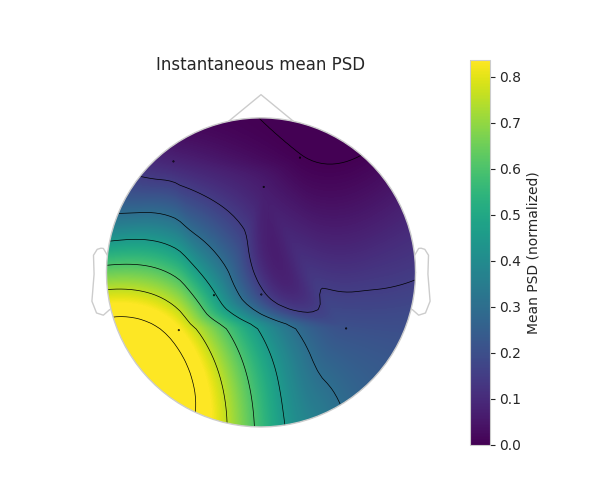

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 4
(813, 7)


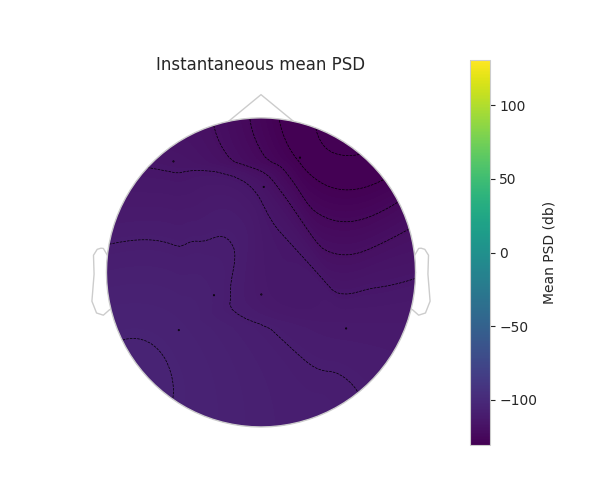

In [24]:
def obtain_mean_psd(bandpass, bandstop, subject_name, use_db = False, normalize = False):
    subject_psd = read_eeg(f"/{subject_name}.edf")
    frequency_of_interest = extract_brain_frequency(subject_psd[available_eeg_channels], 250, bandpass, bandstop, 2, 15)
    windowed_frequency = apply_window(frequency_of_interest)

    mean_psd = compute_psd(windowed_frequency, 250, "hamming", 0.2, 0.15, bandpass, use_db, normalize)  
    print(mean_psd.shape)
  
    return mean_psd

mean_psd = obtain_mean_psd([8, 12], [7,13], subject_name, False, True)
time_slice = mean_psd.to_numpy()[10,:]  #rows - time, cols - channels

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (normalized)")

mean_psd = obtain_mean_psd([8, 12], [7,13], subject_name, True, False)
time_slice = mean_psd.to_numpy()[10,:]  #rows - time, cols - channels

plot_dreem_topomap(time_slice, available_eeg_channels, fs=250, title="Instantaneous mean PSD", value_label="Mean PSD (db)")


### FAA

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 4


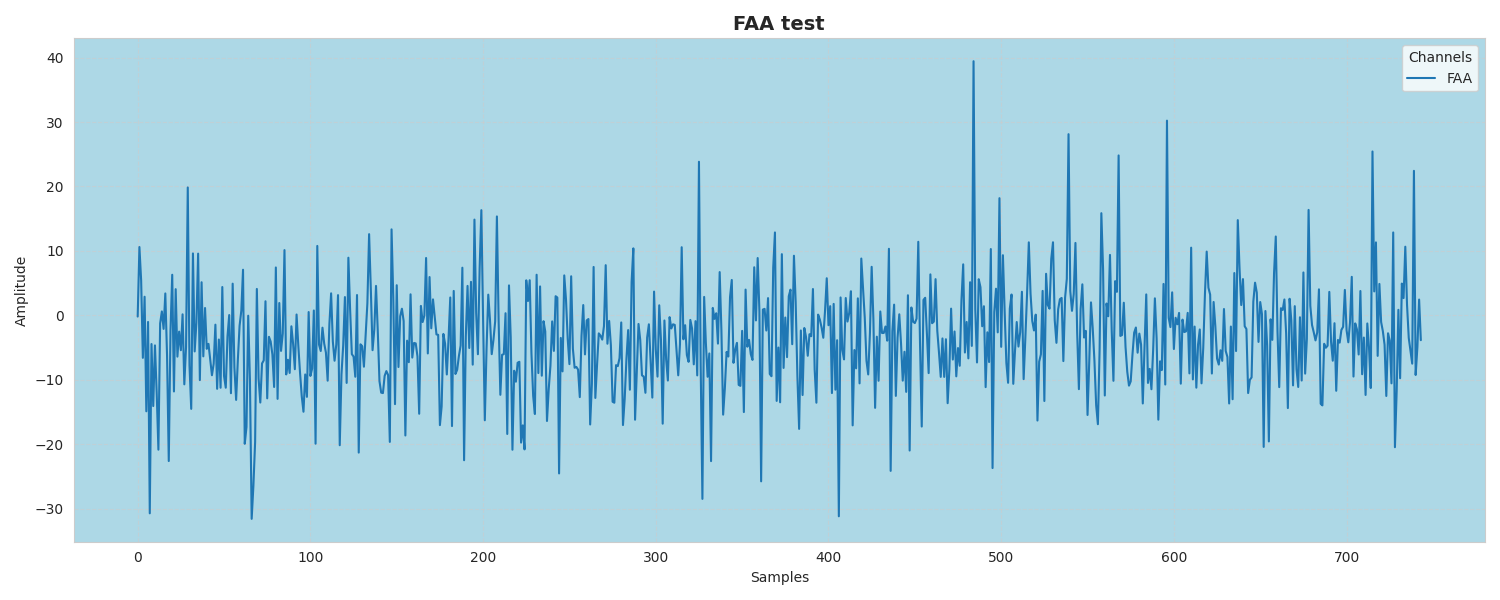

In [25]:
def obtain_faa(subject_name):
    subject_faa = read_eeg(f"/{subject_name}.edf")
    available_eeg_channels = get_rid_of_bad_channels(subject_name, subject_faa, meta)
    alpha_frequency = extract_brain_frequency(subject_faa[available_eeg_channels], 250, [8, 12], [7,13], 2, 15)
    windowed_alpha = apply_window(alpha_frequency)
    mean_alpha_power = compute_psd(windowed_alpha, 250, "hamming", 0.25, 0.25, (8, 12), True, normalize_power=False)[ ["EEG Fp1-F8",
    "EEG Fp1-F7"] ] #log but do not normalize

    # "EEG Fp1-F8" - #frontal right
    # "EEG Fp1-F7" - #frontal left

    faa = mean_alpha_power["EEG Fp1-F8"] - mean_alpha_power["EEG Fp1-F7"] 
    return faa

faa = obtain_faa(subject_name)
plot_dataframe_signals( pd.DataFrame.from_dict({"FAA":faa}) ,"FAA test")


### Activation index

In [29]:
def obtain_activation_index(subject_name):
    #compute beta power
    subject_b = read_eeg(f"/{subject_name}.edf")
    available_b_eeg_channels = get_rid_of_bad_channels(subject_name, subject_b, meta)
    subject_b = subject_b.astype("float128")
    beta_frequency = extract_brain_frequency(subject_b[available_b_eeg_channels], 250, [15, 30], [13, 32], 0.5, 16)
    windowed_beta = apply_window(beta_frequency)
    mean_beta_power = compute_psd(windowed_beta, 250, "hamming", 0.25, 0.25, (15, 30), True)

    #compute delta power
    subject_d = read_eeg(f"/{subject_name}.edf")
    subject_d = subject_d.astype("float128")
    delta_frequency = extract_brain_frequency(subject_d[available_b_eeg_channels], 250, [0.5, 4], [0.007, 5], 0.5, 16)
    windowed_delta = apply_window(delta_frequency)
    mean_delta_power = compute_psd(windowed_delta, 250, "hamming", 0.25, 0.25, (0.5, 4.5), True)

    ai = mean_delta_power / mean_beta_power 
    return ai
test_ai = obtain_activation_index(subject_name)
print(test_ai)

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 6
Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 5
         EEG Fp1-O1  EEG Fp1-O2  EEG Fp1-F7  EEG F8-F7  EEG F7-O1  EEG F8-O2  \
0.124      0.872935    0.874641    0.851857   0.851058   0.824524   0.804084   
0.312      0.924022    0.821666    0.938003   0.943172   0.935816   0.828718   
0.500      0.936534    0.867624    0.926822   0.875401   0.891066   0.857186   
0.688      0.890712    0.871899    0.882458   0.860725   0.850214   0.

In [30]:
def obtain_region_coherence(subject_name, bandpass, bandstop):
    subject_c = read_eeg(f"/{subject_name}.edf")
    available_c_eeg_channels = get_rid_of_bad_channels(subject_name, subject_c, meta)
    subject_c = subject_c.astype("float128")
    frequency_data = extract_brain_frequency(subject_c[available_c_eeg_channels], 250, bandpass, bandstop, 0.5, 16)
    
    coherence_dict = {}
    for o in range(len(available_c_eeg_channels)):
        for i in range(o+1, len(available_c_eeg_channels)):
            o_signal = frequency_data[available_c_eeg_channels[o]]
            i_signal = frequency_data[available_c_eeg_channels[i]]
            
            freq, coherence = spy.signal.coherence(o_signal, i_signal, fs=250, nperseg=130)
            mean_band_coherence = np.mean(coherence)
            coherence_dict[f"{available_c_eeg_channels[o]}x{available_c_eeg_channels[i]}"] = mean_band_coherence 
            
    return coherence_dict
test_coherence = obtain_region_coherence(subject_name, [10,15], [8,17])
print(test_coherence)

Extracting EDF parameters from /home/kaba4ok/Documents/oles_territory/studies_in_Lviv/year4/7_sem/signals/project/data/PSG/DL014/DL014_night03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 34999  =      0.000 ...   139.996 secs...
Filter order: 4
{'EEG Fp1-O1xEEG Fp1-O2': 0.34181299909104954525, 'EEG Fp1-O1xEEG Fp1-F7': 0.12628867477238813686, 'EEG Fp1-O1xEEG F8-F7': 0.11075286871161153356, 'EEG Fp1-O1xEEG F7-O1': 0.3071193150534756963, 'EEG Fp1-O1xEEG F8-O2': 0.24316252117652392109, 'EEG Fp1-O1xEEG Fp1-F8': 0.10309203621434626388, 'EEG Fp1-O2xEEG Fp1-F7': 0.34762716858685351618, 'EEG Fp1-O2xEEG F8-F7': 0.26667603416565490782, 'EEG Fp1-O2xEEG F7-O1': 0.20506808411105617858, 'EEG Fp1-O2xEEG F8-O2': 0.63958897452013765104, 'EEG Fp1-O2xEEG Fp1-F8': 0.15352438518061721745, 'EEG Fp1-F7xEEG F8-F7': 0.6863736230852069888, 'EEG Fp1-F7xEEG F7-O1': 0.65752981296900413205, 'EEG Fp1-F7xEEG F8-O2': 0.15910074660601001358, 'EEG Fp1-F7xEEG Fp1

## Statistical tests

### FAA